In [2]:
import glob, os
from matplotlib import pyplot as plt
import datetime
from PIL import Image
import numpy as np
import cv2

from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn import neural_network
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
#path to our image folder
imagePath=r"C:\Users\Patrick\Documents\TU\2019S\ML\ML_Exercise3\ML_Exercise3\data\CarData2"
_cwd = cwd = r"C:\Users\Patrick\Documents\TU\2019S\ML\ML_Exercise3\ML_Exercise3"
os.chdir(imagePath)
fileNames = glob.glob("*/*.pgm")
targetLabels=[]
for fileName in fileNames:
    if fileName.find("neg") > 0:
        targetLabels.append(0)
    else:
        targetLabels.append(1)

In [4]:
print("Extracting features using PIL/PILLOW" + " (" + str(datetime.datetime.now()) + ")")

data=[]
for index, fileName in enumerate(fileNames):
    imagePIL = Image.open(os.path.join(imagePath, fileName))
    # Not all images in our dataset are in RGB color scheme (e.g. indexed colours)
    # We need to make sure that they are RGB , otherwise we can't expect to have exactly three RGB channels..
    imagePIL = imagePIL.convert('RGB')     
    featureVector=imagePIL.histogram()
    
    if (len(featureVector) != 768): # just a sanity check; with the transformation to RGB, this should never happen
        print("Unexpected length of feature vector: " + str(len(featureVector)) + " in file: " + fileName)

    data.append((featureVector))
print("Extracting features using OpenCV" + " (" + str(datetime.datetime.now()) + ")")
dataOpenCV_1D=[]
dataOpenCV_2D=[]
dataOpenCV_3D=[]

# use our own simple function to flatten the 2D arrays
flatten = lambda l: [item for sublist in l for item in sublist]

for fileName in fileNames:

    # the easiest way would to do the following:
    # imageOpenCV = cv2.imread(imagePath + fileName)

    # However, we have the same issue as before, and it is more difficult in OpenCV to convert to an RGB image
    # Thus we do this using PIL, and then convert to OpenCV ....
    imagePIL = Image.open(os.path.join(imagePath, fileName))
    imagePIL = imagePIL.convert('RGB')
    imageOpenCV = np.array(imagePIL) 
    # Convert RGB to BGR 
    imageOpenCV = imageOpenCV[:, :, ::-1].copy() 

    # Now we split the image in the three channels, B / G / R
    chans = cv2.split(imageOpenCV)
    colors = ("b", "g", "r")

    # First we do also features per channel, but this time, we aggregate them into a smaller number of bins
    # I.e. we do not have 256 values per channel, but less
    featuresOpenCV_1D = []
    bins_1D=64
    for (chan, color) in zip(chans, colors): # we compute the histogram over each channel
        histOpenCV = cv2.calcHist([chan], [0], None, [bins_1D], [0, 256])
        featuresOpenCV_1D.extend(histOpenCV)
    featureVectorOpenCV_1D = flatten(featuresOpenCV_1D) # and append this to our feature vector
    
    dataOpenCV_1D.append(featureVectorOpenCV_1D) # now we append the feature vector to the dataset so far

    if (len(featureVectorOpenCV_1D) != bins_1D*3): # sanity check, in case we had a wrong number of channels...
        print("Unexpected length of feature vector: " + str(len(featureVectorOpenCV_1D)) + " in file: " + fileName)

    # Next - features that look at two channels at the same time
    # E.g. we look at when green and blue have both "high values"
    # We reduce the size of bins further, to not have a too long feature vector
    featuresOpenCV_2D = []
    bins2D=16
    # look at all combinations of channels (R & B, R & G, B & G)
    featuresOpenCV_2D.extend(cv2.calcHist([chans[1], chans[0]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
    featuresOpenCV_2D.extend(cv2.calcHist([chans[1], chans[2]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
    featuresOpenCV_2D.extend(cv2.calcHist([chans[0], chans[2]], [0, 1], None, [bins2D, bins2D], [0, 256, 0, 256]))
    # and add that to our dataset
    featureVectorOpenCV_2D = flatten(featuresOpenCV_2D)
    dataOpenCV_2D.append(featureVectorOpenCV_2D)

    # finally, we look at all three channels at the same time.
    # We further reduce our bin size, because otherwise, this would become very large...
    featuresOpenCV_3D = cv2.calcHist([imageOpenCV], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    # append to our dataset
    featureVectorOpenCV_3D = featuresOpenCV_3D.flatten()
    dataOpenCV_3D.append(featureVectorOpenCV_3D)

        
print(".... done" + " (" + str(datetime.datetime.now()) + ")")



Extracting features using PIL/PILLOW (2019-07-28 16:33:03.933546)
Extracting features using OpenCV (2019-07-28 16:33:04.317546)
.... done (2019-07-28 16:33:05.378546)


In [8]:
trainingSets = [data, dataOpenCV_1D, dataOpenCV_2D, dataOpenCV_3D]

# set up a number of classifiers
classifiers = [("Kneighbors", neighbors.KNeighborsClassifier()),
               ('GaussianNB', naive_bayes.GaussianNB()), 
               ('DecisionTree', tree.DecisionTreeClassifier()),
               ('RandomForest', ensemble.RandomForestClassifier()),
               ('RandomForest_OPT', ensemble.RandomForestClassifier(n_estimators=300, max_features=5)),
               ('SVC', svm.SVC()),
               ('MLP', neural_network.MLPClassifier()),
               ('MLP_OPT', neural_network.MLPClassifier(alpha=0.03, max_iter=500, hidden_layer_sizes=(30,)))
              ]
trainingSet_names = ['data', '1D', '2D', '3D']
arr = []
for iindex, train in enumerate(trainingSets):
    print("\n")
    for jindex, classifier_tuple in enumerate(classifiers):
        if iindex == 0:
            arr.append([])
        print(classifier_tuple[0]) 
        scores = cross_val_score(classifier_tuple[1], train, targetLabels, cv=10)
        #print(cross_val_score(classifier, train, target, cv=3))
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        
        arr[jindex].append(scores.mean())
        X_train, X_test, y_train, y_test =  train_test_split(train, targetLabels, random_state=42)
        classifier_tuple[1].fit(X_train, y_train)
        y_pred = classifier_tuple[1].predict(X_test)
        fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=200)
        plt.rcParams.update({'font.size': 13})
        cm = confusion_matrix(y_test, y_pred)
        df_cm = pd.DataFrame(
            cm, index=["negative", "positive"], columns=["negative", "positive"], 
        )
        g = sns.heatmap(df_cm, annot=True,ax=ax)
        a = plt.title('Confusion Matrix of ' + classifier_tuple[0] + ' for training set ' + trainingSet_names[iindex] + ' (Accuracy: ' + "{:.2f}".format(scores.mean()) + ')')
        g.get_figure().savefig(os.path.join(_cwd,'plots','cm_car_simple_'+trainingSet_names[iindex]+"_"+classifier_tuple[0]+"_{:.0f}".format(scores.mean()*100)+'.png'))
        plt.close()



Kneighbors
Accuracy: 0.59 (+/- 0.34)
GaussianNB
Accuracy: 0.59 (+/- 0.40)
DecisionTree
Accuracy: 0.66 (+/- 0.19)
RandomForest
Accuracy: 0.67 (+/- 0.25)
RandomForest_OPT
Accuracy: 0.72 (+/- 0.26)
SVC
Accuracy: 0.62 (+/- 0.00)
MLP
Accuracy: 0.58 (+/- 0.14)
MLP_OPT
Accuracy: 0.54 (+/- 0.10)


Kneighbors
Accuracy: 0.57 (+/- 0.44)
GaussianNB
Accuracy: 0.57 (+/- 0.53)
DecisionTree
Accuracy: 0.66 (+/- 0.25)
RandomForest
Accuracy: 0.68 (+/- 0.31)
RandomForest_OPT
Accuracy: 0.73 (+/- 0.26)
SVC
Accuracy: 0.62 (+/- 0.00)
MLP
Accuracy: 0.61 (+/- 0.14)
MLP_OPT
Accuracy: 0.59 (+/- 0.16)


Kneighbors
Accuracy: 0.65 (+/- 0.18)
GaussianNB
Accuracy: 0.57 (+/- 0.52)
DecisionTree
Accuracy: 0.69 (+/- 0.20)
RandomForest
Accuracy: 0.67 (+/- 0.22)
RandomForest_OPT
Accuracy: 0.71 (+/- 0.16)
SVC
Accuracy: 0.62 (+/- 0.00)
MLP
Accuracy: 0.57 (+/- 0.22)
MLP_OPT
Accuracy: 0.62 (+/- 0.19)


Kneighbors
Accuracy: 0.68 (+/- 0.15)
GaussianNB
Accuracy: 0.57 (+/- 0.53)
DecisionTree
Accuracy: 0.66 (+/- 0.24)
RandomForest

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators wil

In [12]:
classifier_names = [clf_tuple[0] for clf_tuple in classifiers]
df = pd.DataFrame(data=arr, index=classifier_names,columns=trainingSet_names)

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text xticklabel objects>)

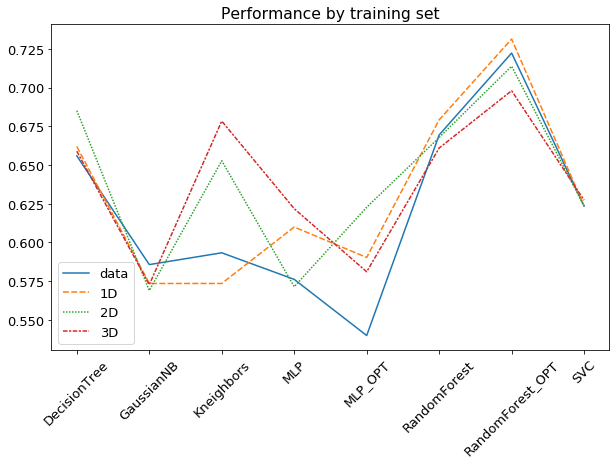

In [13]:
_, ax = plt.subplots(figsize=(10, 6))
plt.title('Performance by training set')
sns.lineplot(data=df, ax=ax)
plt.xticks(rotation=45)

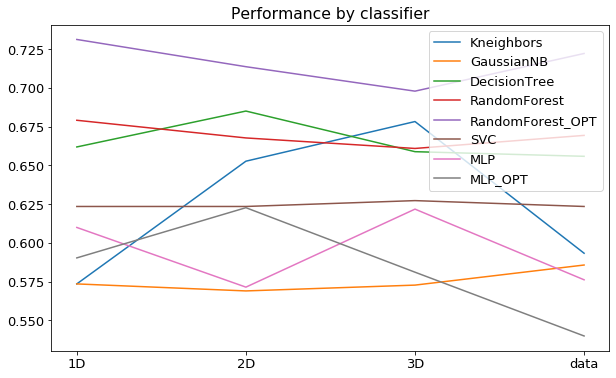

In [14]:
_, ax = plt.subplots(figsize=(10, 6))
plt.title('Performance by classifier')
sns.lineplot(data=df.T, ax=ax, dashes=False)

In [29]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [30]:
rfclf_param_grid = {
  "n_estimators": [10, 100, 300],
  "max_depth": [5, 7, None],
  "max_features": [5, "auto"],
  }
rfclf = ensemble.RandomForestClassifier()
rfclf_grid_search = GridSearchCV(rfclf, param_grid=rfclf_param_grid, cv=10, n_jobs=1)
rfclf_grid_search.fit(dataOpenCV_3D, targetLabels)
report(rfclf_grid_search.cv_results_) 

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Model with rank: 1
Mean validation score: 0.711 (std: 0.079)
Parameters: {'max_depth': None, 'max_features': 5, 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.710 (std: 0.078)
Parameters: {'max_depth': None, 'max_features': 5, 'n_estimators': 300}

Model with rank: 3
Mean validation score: 0.700 (std: 0.087)
Parameters: {'max_depth': 7, 'max_features': 5, 'n_estimators': 100}



In [31]:
mlpclf_param_grid = {"hidden_layer_sizes": [(30,), (100,), (15,15), (100,30), (50,50)], #, (30, 30, 20), smaller ones e.g. 10; 15; 15,15 worse
              "activation": [ "relu"], #tanh worse
              "solver": ["adam"], #lbfgs worse
              "alpha": [0.0001, 0.03], #0.0001, 0.005, 
              "max_iter": [100, 200, 500]} # 100 worse, does not converge
mlpclf = neural_network.MLPClassifier()
mlpclf_grid_search = GridSearchCV(mlpclf, param_grid=mlpclf_param_grid, cv=10, n_jobs=1)
mlpclf_grid_search.fit(dataOpenCV_3D, targetLabels)
report(mlpclf_grid_search.cv_results_) 

c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
c:\users\patrick\documents\tu\2019s\ml\ml_exercise3\ml_exercise3\venv\lib\site-packages\sklearn\neural_net

Model with rank: 1
Mean validation score: 0.654 (std: 0.076)
Parameters: {'activation': 'relu', 'alpha': 0.03, 'hidden_layer_sizes': (30,), 'max_iter': 500, 'solver': 'adam'}

Model with rank: 2
Mean validation score: 0.651 (std: 0.042)
Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'max_iter': 200, 'solver': 'adam'}

Model with rank: 3
Mean validation score: 0.648 (std: 0.064)
Parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 30), 'max_iter': 100, 'solver': 'adam'}



In [ ]:
"{:.0f}".format(scores.mean()*100)